<a href="https://colab.research.google.com/github/hhuang45/OmicSelector/blob/master/Clustering2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

--- Loading and Preparing Iris Dataset ---
Dataset loaded: 150 samples, 4 features, 3 true clusters.

--- Applying CBTR (Adapted for non-sequential data) ---
Starting Adapted CBTR Clustering...
Adapted CBTR finished.

--- Applying TIP Clustering ---
Starting TIP Gibbs Sampler (200 burn-in, 200 samples)...
  Iteration 50/400
  Iteration 100/400
  Iteration 150/400
  Iteration 200/400
  Iteration 250/400
  Iteration 300/400
  Iteration 350/400
  Iteration 400/400
Estimated number of clusters from PSM: 3
TIP Clustering finished.

--- Applying GMM (MCLUST) ---

--- Applying k-means Clustering ---

--- Applying DBSCAN Clustering ---

--- Applying Hierarchical Clustering Methods ---
  - Running H-Clust (Single)...
  - Running H-Clust (Complete)...
  - Running H-Clust (Average)...
  - Running H-Clust (Centroid)...


--- Clustering Performance Comparison on Iris Dataset ---

                    k_true  k_found       ARI
GMM (MCLUST)             3      3.0  0.903874
DBSCAN                   3  

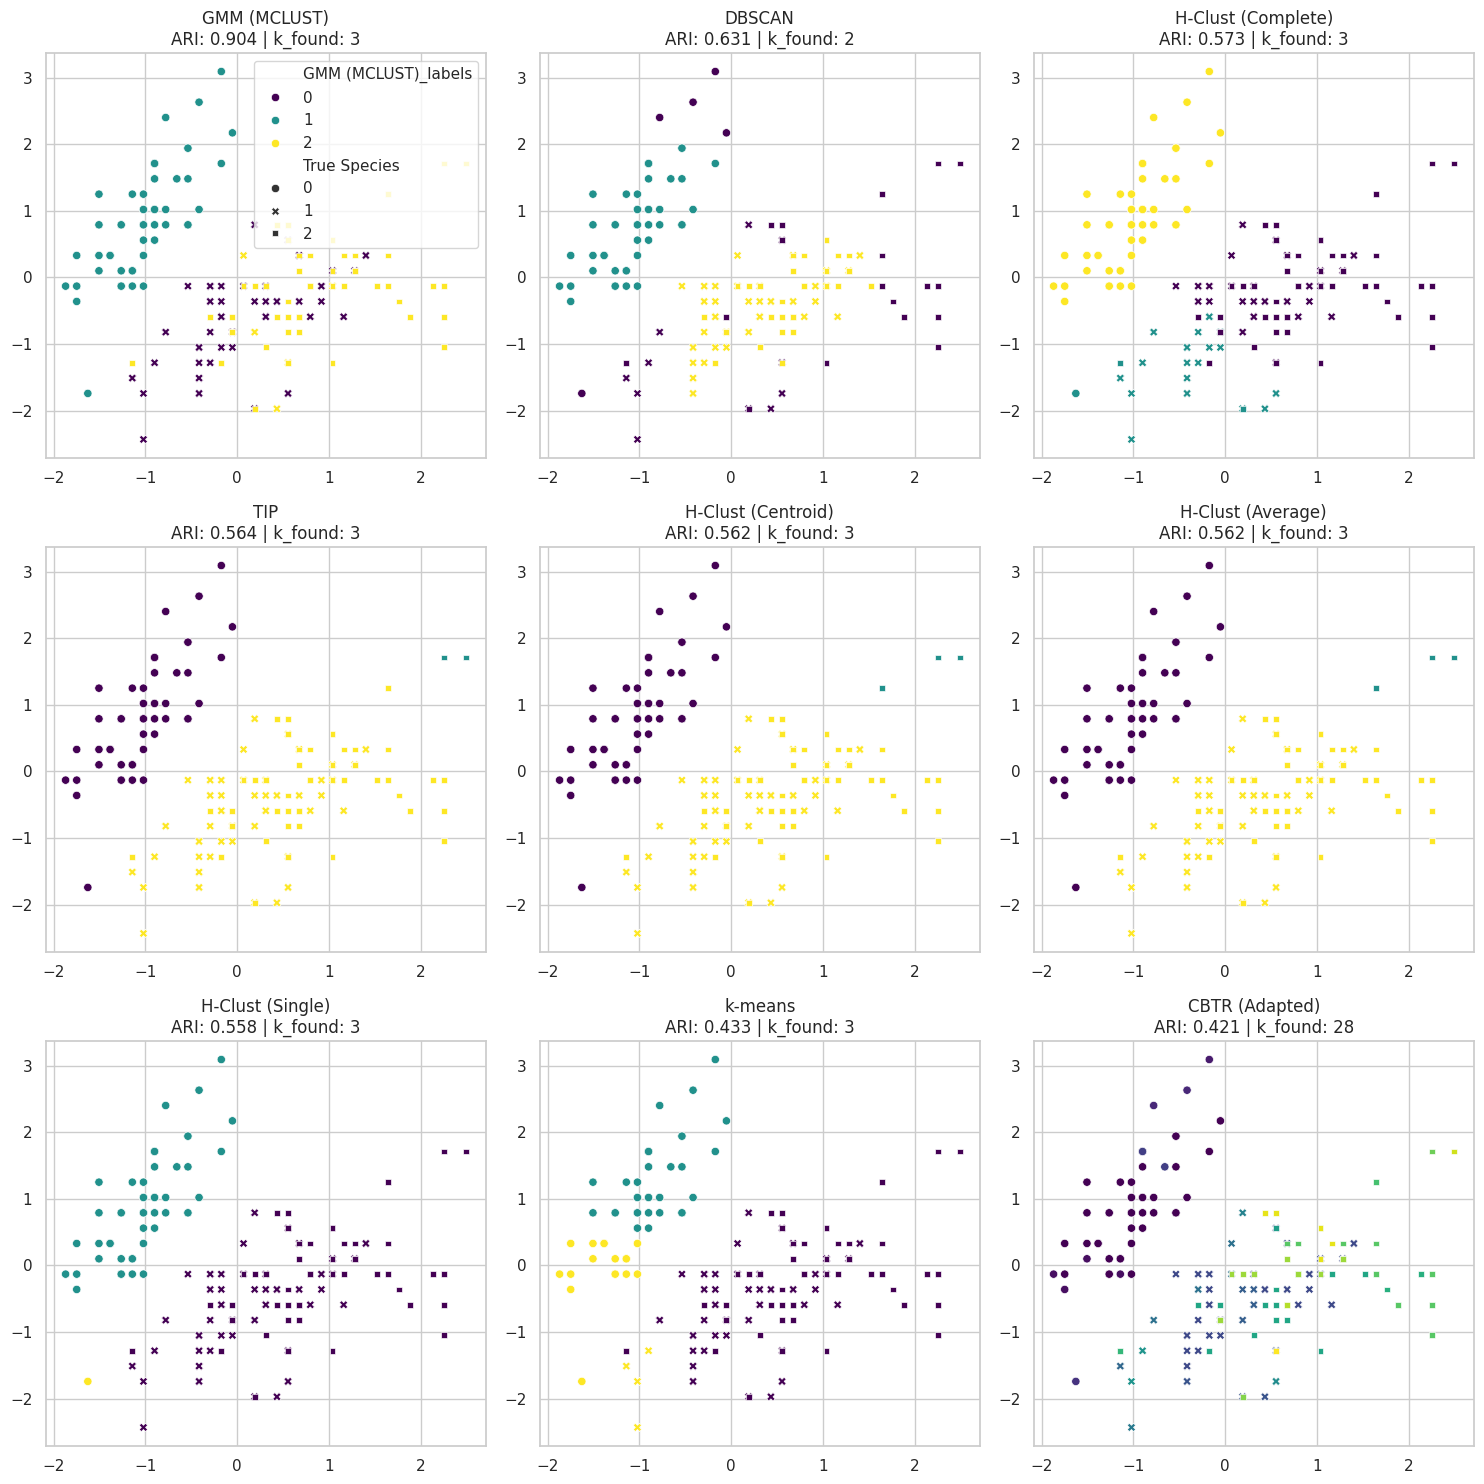


--- Demonstration Complete ---


In [ ]:
# -*- coding: utf-8 -*-
"""
STA5206: Comprehensive Clustering Comparison on the Iris Dataset

This script applies a full suite of standard, model-based, and specialized
clustering algorithms to the classic Iris benchmark dataset. This version
correctly includes the Table Invitation Prior (TIP) method.

The purpose is to evaluate the performance and behavior of all methods, including
the adapted TIP and CBTR, on a well-understood, non-sequential problem.

Algorithms Compared:
- TIP (Table Invitation Prior)
- CBTR (Clustering Based on Trajectory Reconstruction) - Adapted
- GMM (MCLUST - Gaussian Mixture)
- DBSCAN
- k-means
- Hierarchical (Single, Complete, Average, Centroid)
"""

# --- 1. Setup and Library Imports ---
!pip install ruptures -q

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict

# Clustering and evaluation tools
from sklearn.cluster import KMeans, DBSCAN
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import load_iris
from scipy.spatial.distance import pdist, squareform
from scipy.stats import multivariate_t, poisson
from scipy.cluster.hierarchy import linkage, fcluster
from sklearn.metrics import adjusted_rand_score

# Change point detection library
import ruptures as rpt

# Set a random seed for reproducibility
np.random.seed(42)
sns.set_theme(style="whitegrid")


# --- 2. Algorithm Implementations (TIP and Adapted CBTR) ---

class TIPClustering:
    """
    Implementation of the Table Invitation Prior (TIP) for Bayesian clustering.
    Follows the algorithm described in Harrison, He, Huang (2022).
    """
    def __init__(self, n_burn=200, n_samples=200):
        self.n_burn = n_burn; self.n_samples = n_samples; self.total_iter = n_burn + n_samples
        self.posterior_samples = []; self.final_labels = None; self.psm = None; self.k_est = 0
    def _calculate_similarity(self, X):
        dist_matrix = squareform(pdist(X, 'euclidean')); median_dist = np.median(dist_matrix[np.triu_indices(self.n_subjects, k=1)])
        if median_dist == 0: median_dist = 1.0
        self.similarity_matrix = np.exp(-1.0 / median_dist * dist_matrix); self.dist_matrix = dist_matrix
    def _estimate_n_tau(self, r):
        dr = np.sort(np.delete(self.dist_matrix[r, :], r)); algo = rpt.Binseg(model="l2").fit(dr)
        try: chp_locs = algo.predict(n_bkps=2); first_chp = chp_locs[0]
        except rpt.exceptions.NotEnoughPoints: first_chp = 1
        return min(poisson.rvs(mu=max(1, first_chp)), self.n_subjects - 1)
    def _log_posterior_predictive(self, x, cluster_data, p, mu0, lambda0, Psi0, nu0):
        n_k = len(cluster_data); x_bar = np.mean(cluster_data, axis=0) if n_k > 0 else np.zeros(p)
        lambda1 = lambda0 + n_k; nu1 = nu0 + n_k; mu1 = (lambda0 * mu0 + n_k * x_bar) / lambda1
        S_k = np.cov(cluster_data.T) * (n_k - 1) if n_k > 1 else np.zeros((p,p))
        diff_mu0 = (x_bar - mu0).reshape(p, 1); Psi1 = Psi0 + S_k + (lambda0 * n_k / lambda1) * (diff_mu0 @ diff_mu0.T)
        df = nu1 - p + 1; loc = mu1; shape = Psi1 * (lambda1 + 1) / (lambda1 * df)
        try: return multivariate_t.logpdf(x, loc=loc, shape=shape, df=df)
        except np.linalg.LinAlgError: return multivariate_t.logpdf(x, loc=loc, shape=shape + np.eye(p) * 1e-6, df=df)
    def fit(self, X):
        self.n_subjects, self.p = X.shape; self._calculate_similarity(X)
        mu0, lambda0, nu0 = np.mean(X, axis=0), 1.0, self.p
        try: Psi0 = np.linalg.inv(np.cov(X.T) * (self.p - 1))
        except np.linalg.LinAlgError: Psi0 = np.linalg.inv(np.cov(X.T) * (self.p - 1) + np.eye(self.p) * 1e-6)
        c = np.ones(self.n_subjects, dtype=int); print(f"Starting TIP Gibbs Sampler ({self.n_burn} burn-in, {self.n_samples} samples)...")
        for t in range(self.total_iter):
            if (t+1) % 50 == 0: print(f"  Iteration {t+1}/{self.total_iter}")
            r_idx = np.random.randint(0, self.n_subjects); n_tau_r = self._estimate_n_tau(r_idx)
            similar_indices = np.argsort(self.similarity_matrix[r_idx, :])[-n_tau_r:]
            c_proposal = np.copy(c); c_proposal[similar_indices] = len(np.unique(c)) + 1
            unique_clusters_proposal = np.unique(c_proposal)
            for i in range(self.n_subjects):
                log_probs = []
                for k in unique_clusters_proposal:
                    members_k = np.where(c_proposal == k)[0]
                    log_likelihood = self._log_posterior_predictive(X[i], X[members_k, :], self.p, mu0, lambda0, Psi0, nu0)
                    log_probs.append(np.log(np.sum(self.similarity_matrix[i, members_k]) + 1e-9) + log_likelihood)
                probs = np.exp(log_probs - np.max(log_probs)); c[i] = np.random.choice(unique_clusters_proposal, p=probs/np.sum(probs))
            c = pd.factorize(c)[0] + 1
            if t >= self.n_burn: self.posterior_samples.append(c.copy())
        self._summarize_posteriors(); print("TIP Clustering finished."); return self.final_labels
    def _summarize_posteriors(self):
        if not self.posterior_samples: self.final_labels = np.ones(self.n_subjects, dtype=int); return
        self.psm = np.zeros((self.n_subjects, self.n_subjects))
        for c_sample in self.posterior_samples: self.psm += (c_sample[:, None] == c_sample)
        self.psm /= len(self.posterior_samples); np.fill_diagonal(self.psm, 1.0)
        condensed_psm_dist = squareform(1 - self.psm); linked = linkage(condensed_psm_dist, method='average')
        last_merges = linked[-20:, 2]
        if len(last_merges) > 1: jumps = np.diff(last_merges); self.k_est = (20 - np.argmax(jumps)) if len(jumps) > 0 else 2
        else: self.k_est = 1
        print(f"Estimated number of clusters from PSM: {self.k_est}"); self.final_labels = fcluster(linked, self.k_est, criterion='maxclust')

class CBTR_Adapted_Clustering:
    """ An adapted version of CBTR for non-trajectory data using synthetic time. """
    def __init__(self, time_window=10, dist_threshold=0.8):
        self.time_window = time_window # Search a small number of "future" points
        self.dist_threshold = dist_threshold # Distance threshold for linking
    def fit(self, df):
        print("Starting Adapted CBTR Clustering...")
        data = df.sort_values('time').to_dict('records')
        n = len(data); links = -np.ones(n, dtype=int)
        for i in range(n):
            xi = data[i]; best_j, min_dist = -1, np.inf
            for j in range(i + 1, min(i + 1 + self.time_window, n)):
                xj = data[j]
                dist = np.sqrt((xi['f1'] - xj['f1'])**2 + (xi['f2'] - xj['f2'])**2 +
                               (xi['f3'] - xj['f3'])**2 + (xi['f4'] - xj['f4'])**2)
                if dist < min_dist: min_dist, best_j = dist, j
            if best_j != -1 and min_dist < self.dist_threshold:
                links[i] = best_j
        adj = defaultdict(list)
        for i, j in enumerate(links):
            if j != -1: adj[i].append(int(j)); adj[int(j)].append(i)
        cluster_labels = -np.ones(n, dtype=int); current_cluster_id = 0; visited = set()
        for i in range(n):
            if i not in visited:
                current_cluster_id += 1; component = []; q = [i]; visited.add(i)
                while q:
                    u = q.pop(0); component.append(u)
                    for v in adj[u]:
                        if v not in visited: visited.add(v); q.append(v)
                for node in component: cluster_labels[node] = current_cluster_id
        print("Adapted CBTR finished."); return cluster_labels

# --- 3. Load and Prepare Iris Data ---
print("--- Loading and Preparing Iris Dataset ---")
iris = load_iris()
X_iris = iris.data
y_iris = iris.target
feature_names = iris.feature_names
true_k = len(np.unique(y_iris))
scaler = StandardScaler()
X_iris_scaled = scaler.fit_transform(X_iris)
print(f"Dataset loaded: {X_iris.shape[0]} samples, {X_iris.shape[1]} features, {true_k} true clusters.")

# --- 4. Apply All Clustering Methods ---
results = {}; label_arrays = {}

print("\n--- Applying CBTR (Adapted for non-sequential data) ---")
iris_df_cbtr = pd.DataFrame(X_iris_scaled, columns=['f1', 'f2', 'f3', 'f4'])
iris_df_cbtr['time'] = np.arange(len(iris_df_cbtr))
cbtr_model = CBTR_Adapted_Clustering(); label_arrays['CBTR (Adapted)'] = cbtr_model.fit(iris_df_cbtr)
results['CBTR (Adapted)'] = {'ARI': adjusted_rand_score(y_iris, label_arrays['CBTR (Adapted)']), 'k_found': len(np.unique(label_arrays['CBTR (Adapted)']))}

print("\n--- Applying TIP Clustering ---")
tip_model = TIPClustering(n_burn=200, n_samples=200); label_arrays['TIP'] = tip_model.fit(X_iris_scaled)
results['TIP'] = {'ARI': adjusted_rand_score(y_iris, label_arrays['TIP']), 'k_found': len(np.unique(label_arrays['TIP']))}

print("\n--- Applying GMM (MCLUST) ---")
gmm = GaussianMixture(n_components=true_k, random_state=42, n_init=10).fit(X_iris_scaled)
label_arrays['GMM (MCLUST)'] = gmm.predict(X_iris_scaled)
results['GMM (MCLUST)'] = {'ARI': adjusted_rand_score(y_iris, label_arrays['GMM (MCLUST)']), 'k_found': true_k}

print("\n--- Applying k-means Clustering ---")
kmeans = KMeans(n_clusters=true_k, n_init='auto', random_state=42).fit(X_iris_scaled)
label_arrays['k-means'] = kmeans.labels_
results['k-means'] = {'ARI': adjusted_rand_score(y_iris, label_arrays['k-means']), 'k_found': true_k}

print("\n--- Applying DBSCAN Clustering ---")
dbscan = DBSCAN(eps=0.5, min_samples=5).fit(X_iris_scaled); label_arrays['DBSCAN'] = dbscan.labels_
non_noise_mask = dbscan.labels_ != -1
ari_dbscan = adjusted_rand_score(y_iris[non_noise_mask], dbscan.labels_[non_noise_mask]) if sum(non_noise_mask) > 0 else 0
results['DBSCAN'] = {'ARI': ari_dbscan, 'k_found': len(np.unique(dbscan.labels_[non_noise_mask]))}

print("\n--- Applying Hierarchical Clustering Methods ---")
hclust_methods = {'H-Clust (Single)': 'single', 'H-Clust (Complete)': 'complete', 'H-Clust (Average)': 'average', 'H-Clust (Centroid)': 'centroid'}
for name, method in hclust_methods.items():
    print(f"  - Running {name}...")
    linked = linkage(X_iris_scaled, method=method); label_arrays[name] = fcluster(linked, t=true_k, criterion='maxclust')
    results[name] = {'ARI': adjusted_rand_score(y_iris, label_arrays[name]), 'k_found': true_k}

# --- 5. Report and Compare Accuracy Rates ---
print("\n\n--- Clustering Performance Comparison on Iris Dataset ---\n")
results_df = pd.DataFrame(results).T; results_df['k_true'] = true_k
results_df = results_df[['k_true', 'k_found', 'ARI']].sort_values(by='ARI', ascending=False); print(results_df)

# --- 6. Visualize Clustering Results ---
print("\n--- Visualizing Clustering Results on First Two Features ---")
plot_df = pd.DataFrame(X_iris_scaled[:, :2], columns=['Sepal Length (Scaled)', 'Sepal Width (Scaled)'])
plot_df['True Species'] = y_iris
n_methods = len(label_arrays); n_cols = 3; n_rows = (n_methods + n_cols - 1) // n_cols
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, n_rows * 5))
axes = axes.flatten()
sorted_methods = results_df.sort_values(by='ARI', ascending=False).index.tolist()
for i, method in enumerate(sorted_methods):
    labels = label_arrays[method]
    plot_df[f'{method}_labels'] = labels
    sns.scatterplot(x='Sepal Length (Scaled)', y='Sepal Width (Scaled)', hue=f'{method}_labels',
                    style='True Species', data=plot_df, palette='viridis', ax=axes[i],
                    legend='full' if i == 0 else False)
    ari_score = results[method]['ARI']; k_found = results[method]['k_found']
    axes[i].set_title(f'{method}\nARI: {ari_score:.3f} | k_found: {k_found}')
    axes[i].set_xlabel(''); axes[i].set_ylabel('')
for j in range(i + 1, len(axes)): fig.delaxes(axes[j])
plt.tight_layout()
plt.show()
print("\n--- Demonstration Complete ---")

In [ ]:
pip install numpy pandas scikit-learn scipy ruptures folium